In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Task 3 - Deep versus wide networks

## Data Generation for Noisy-XOR Problem

We'll generate data points according to the formula:
$(x_1, x_2, y) = (m_1 + s\eta_1, m_2 + s\eta_2, m_1 \text{ xor } m_2)$

where $(m_1, m_2) \in \{(0,0), (0,1), (1,0), (1,1)\}$ are cluster centers, $s$ is the standard deviation, and $\eta_1, \eta_2$ are normally distributed random variables.

In [29]:
class NoisyXORGenerator:
    def __init__(self, s=0.1, seed=None):
        # s: standard deviation for noise
        # seed: random seed for reproducibility
        self.s = s
        self.seed = seed
        
        # Four cluster centers for XOR problem
        self.cluster_centers = np.array([
            [0, 0],  # XOR output: 0
            [0, 1],  # XOR output: 1
            [1, 0],  # XOR output: 1
            [1, 1]   # XOR output: 0
        ])
        
        # XOR labels for each cluster
        self.cluster_labels = np.array([0, 1, 1, 0])
    
    def generate(self, n_samples):
        # Generate noisy XOR data with n_samples points
        if self.seed is not None:
            np.random.seed(self.seed)
        
        # Distribute samples evenly across clusters
        samples_per_cluster = n_samples // 4
        remainder = n_samples % 4
        
        X = []
        y = []
        
        for i in range(4):
            n = samples_per_cluster + (1 if i < remainder else 0)
            
            # Add Normal(0,1) noise scaled by s
            eta = np.random.randn(n, 2)
            cluster_samples = self.cluster_centers[i] + self.s * eta
            
            X.append(cluster_samples)
            y.append(np.full(n, self.cluster_labels[i]))
        
        X = np.vstack(X)
        y = np.concatenate(y)
        
        # Shuffle the data
        indices = np.random.permutation(n_samples)
        X = X[indices]
        y = y[indices]
        
        return X, y
    
    def generate_train_test(self, n_train=2000, n_test=500):
        # Generate separate training and test sets
        X_train, y_train = self.generate(n_train)
        
        # Use different seed for test data
        old_seed = self.seed
        if self.seed is not None:
            self.seed += 1
        
        X_test, y_test = self.generate(n_test)
        
        # Restore original seed
        self.seed = old_seed
        
        return X_train, X_test, y_train, y_test

# Create generator and generate sample dataset
generator = NoisyXORGenerator(s=0.1, seed=42)
X, y = generator.generate(1000)

print(f"Generated {len(X)} samples")
print(f"Feature shape: {X.shape}")
print(f"Label shape: {y.shape}")
print(f"Class distribution: {np.bincount(y.astype(int))}")

Generated 1000 samples
Feature shape: (1000, 2)
Label shape: (1000,)
Class distribution: [500 500]


### Visualization of the Generated Data

Let's visualize the noisy-XOR dataset with different noise levels to understand the problem better.

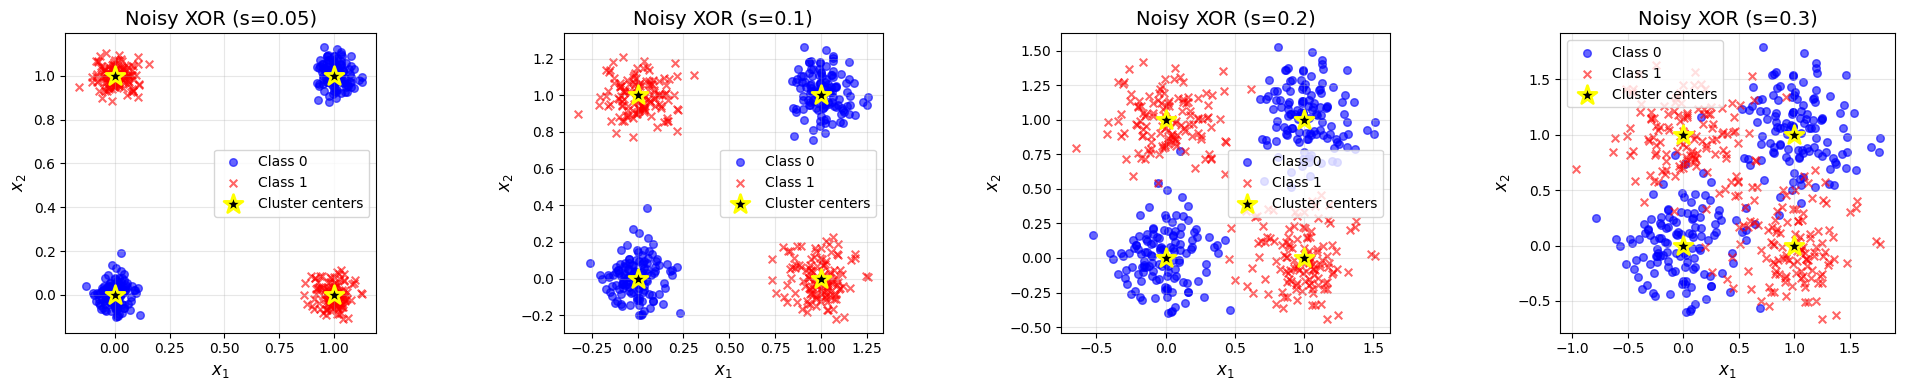

In [30]:
def visualize_noisy_xor(n_samples=500, noise_levels=[0.05, 0.1, 0.2, 0.3]):
    # Visualize noisy XOR data with different noise levels
    fig, axes = plt.subplots(1, len(noise_levels), figsize=(5*len(noise_levels), 4))
    
    if len(noise_levels) == 1:
        axes = [axes]
    
    for ax, s in zip(axes, noise_levels):
        gen = NoisyXORGenerator(s=s, seed=42)
        X, y = gen.generate(n_samples)
        
        # Plot class 0 and 1
        mask_0 = y == 0
        mask_1 = y == 1
        ax.scatter(X[mask_0, 0], X[mask_0, 1], 
                  c='blue', marker='o', s=30, alpha=0.6, label='Class 0')
        ax.scatter(X[mask_1, 0], X[mask_1, 1], 
                  c='red', marker='x', s=30, alpha=0.6, label='Class 1')
        
        # Mark cluster centers
        centers = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
        ax.scatter(centers[:, 0], centers[:, 1], 
                  c='black', marker='*', s=200, 
                  edgecolors='yellow', linewidths=2, 
                  label='Cluster centers', zorder=5)
        
        ax.set_xlabel('$x_1$', fontsize=12)
        ax.set_ylabel('$x_2$', fontsize=12)
        ax.set_title(f'Noisy XOR (s={s})', fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        
    plt.tight_layout()
    plt.show()

# Visualize with different noise levels
visualize_noisy_xor(n_samples=500, noise_levels=[0.05, 0.1, 0.2, 0.3])

### Train/Test Split

Let's create training and test datasets for model evaluation.

In [31]:
# Create datasets using the generator
generator = NoisyXORGenerator(s=0.1, seed=42)
X_train, X_test, y_train, y_test = generator.generate_train_test(n_train=2000, n_test=500)

print("Training set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Class distribution: {np.bincount(y_train.astype(int))}")
print()
print("Test set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Class distribution: {np.bincount(y_test.astype(int))}")

Training set:
  X_train shape: (2000, 2)
  y_train shape: (2000,)
  Class distribution: [1000 1000]

Test set:
  X_test shape: (500, 2)
  y_test shape: (500,)
  Class distribution: [250 250]


### Decision Boundary Visualization Helper

This function will be useful later to visualize the decision boundaries learned by neural networks.

In [32]:
def plot_decision_boundary(model, X, y, title="Decision Boundary", resolution=0.01):
    # Plot decision boundary for a binary classifier
    # model: trained model with predict method
    # X: input features, y: true labels
    
    # Create mesh grid for decision boundary
    x_min, x_max = X[:, 0].min() - 0.3, X[:, 0].max() + 0.3
    y_min, y_max = X[:, 1].min() - 0.3, X[:, 1].max() + 0.3
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    
    # Predict on the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, levels=1, cmap='RdBu')
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    # Plot data points
    mask_0 = y == 0
    mask_1 = y == 1
    plt.scatter(X[mask_0, 0], X[mask_0, 1], 
               c='blue', marker='o', s=30, alpha=0.6, label='Class 0', edgecolors='k')
    plt.scatter(X[mask_1, 0], X[mask_1, 1], 
               c='red', marker='x', s=30, alpha=0.6, label='Class 1')
    
    # Mark cluster centers
    centers = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    plt.scatter(centers[:, 0], centers[:, 1], 
               c='black', marker='*', s=200, 
               edgecolors='yellow', linewidths=2, 
               label='Cluster centers', zorder=5)
    
    plt.xlabel('$x_1$', fontsize=12)
    plt.ylabel('$x_2$', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Decision boundary visualization function defined.")

Decision boundary visualization function defined.


In [33]:
class DynamicXORModel(nn.Module):
    def __init__(self, input_dim=2, hidden_layers=1, hidden_dim=10, output_dim=1):
        super(DynamicXORModel, self).__init__()
        layers = []
        
        current_dim = input_dim
        
        # Create hidden layers
        for _ in range(hidden_layers):
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.ReLU())
            current_dim = hidden_dim
            
        # Output layer
        layers.append(nn.Linear(current_dim, output_dim))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)
    
    def predict(self, X):
        self.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X_tensor = torch.FloatTensor(X)
            else:
                X_tensor = X
            predictions = self.forward(X_tensor)
            return predictions.numpy()

In [34]:
# Prepare data for PyTorch
# Convert numpy arrays to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1) # Add dimension for BCELoss
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Data prepared: {len(train_dataset)} training samples, {len(test_dataset)} test samples.")

Data prepared: 2000 training samples, 500 test samples.


In [35]:
def train_loop(model, train_loader, val_loader, criterion, optimizer, epochs=100, verbose=True):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
            
    return train_losses, val_losses

Epoch 10/100 | Train Loss: 0.0129 | Val Loss: 0.0107
Epoch 20/100 | Train Loss: 0.0033 | Val Loss: 0.0028
Epoch 20/100 | Train Loss: 0.0033 | Val Loss: 0.0028
Epoch 30/100 | Train Loss: 0.0015 | Val Loss: 0.0013
Epoch 30/100 | Train Loss: 0.0015 | Val Loss: 0.0013
Epoch 40/100 | Train Loss: 0.0009 | Val Loss: 0.0007
Epoch 40/100 | Train Loss: 0.0009 | Val Loss: 0.0007
Epoch 50/100 | Train Loss: 0.0006 | Val Loss: 0.0005
Epoch 50/100 | Train Loss: 0.0006 | Val Loss: 0.0005
Epoch 60/100 | Train Loss: 0.0004 | Val Loss: 0.0003
Epoch 60/100 | Train Loss: 0.0004 | Val Loss: 0.0003
Epoch 70/100 | Train Loss: 0.0003 | Val Loss: 0.0002
Epoch 70/100 | Train Loss: 0.0003 | Val Loss: 0.0002
Epoch 80/100 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 80/100 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 90/100 | Train Loss: 0.0002 | Val Loss: 0.0001
Epoch 90/100 | Train Loss: 0.0002 | Val Loss: 0.0001
Epoch 100/100 | Train Loss: 0.0002 | Val Loss: 0.0001
Epoch 100/100 | Train Loss: 0.0002 | Val Loss

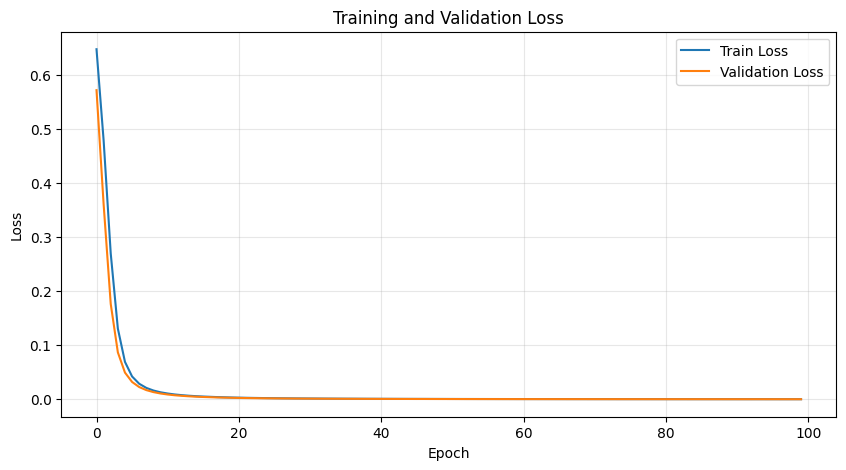

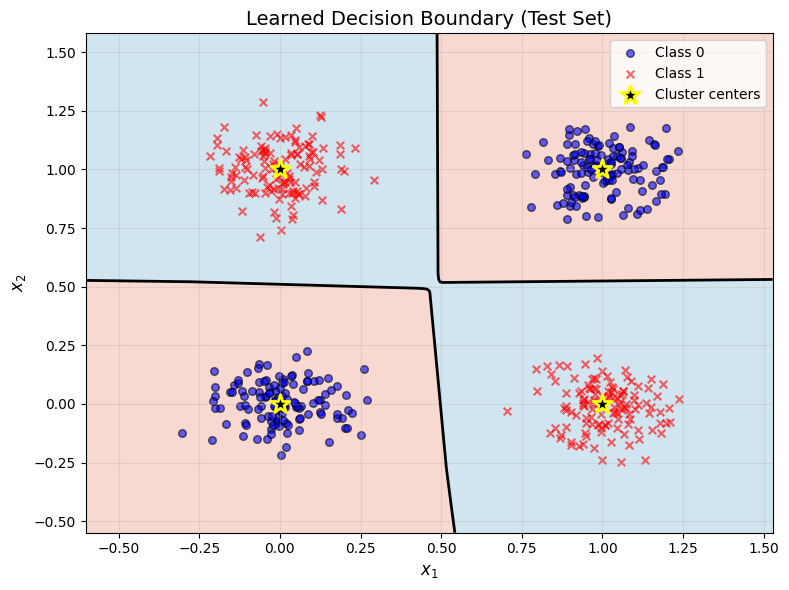

In [36]:
# Initialize model, criterion, and optimizer
# Using 1 hidden layer with 20 neurons as a baseline
model = DynamicXORModel(hidden_layers=1, hidden_dim=20)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
train_losses, val_losses = train_loop(model, train_loader, test_loader, criterion, optimizer, epochs=100)

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot decision boundary
plot_decision_boundary(model, X_test, y_test, title="Learned Decision Boundary (Test Set)")

## Experiment: Testing Network Architectures

We will now test a range of network architectures to see how depth and width affect performance on the noisy-XOR problem.
We will test combinations of:
- Depth (number of hidden layers): 0, 1, 2, 3
- Width (neurons per hidden layer): 1, 2, 3

For each combination, we will train the model multiple times and report the mean and standard deviation of the test loss.

In [37]:
# Experiment Configuration
depths = [0, 1, 2, 3]
widths = [1, 2, 3]
n_repetitions = 5  # Number of runs per configuration
epochs = 100

results_list = []

print(f"Starting experiment with depths={depths}, widths={widths}, repetitions={n_repetitions}")
print("-" * 60)
print(f"{'Depth':<10} {'Width':<10} {'Mean Loss':<15} {'Std Dev':<15}")
print("-" * 60)

for depth in depths:
    for width in widths:
        config_losses = []
        
        for i in range(n_repetitions):
            # Initialize model with specific architecture
            # Note: For depth=0, width parameter is ignored by our logic but we pass it anyway
            model = DynamicXORModel(input_dim=2, hidden_layers=depth, hidden_dim=width, output_dim=1)
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=0.01)
            
            # Train (suppress output with verbose=False)
            _, val_losses = train_loop(model, train_loader, test_loader, criterion, optimizer, epochs=epochs, verbose=False)
            
            # Record final validation loss
            final_loss = val_losses[-1]
            config_losses.append(final_loss)
            
        mean_loss = np.mean(config_losses)
        std_loss = np.std(config_losses)
        
        results_list.append({
            'Depth': depth, 
            'Width': width, 
            'Mean Loss': mean_loss, 
            'Std Dev': std_loss
        })
        
        print(f"{depth:<10} {width:<10} {mean_loss:<15.4f} {std_loss:<15.4f}")

# Store results in a DataFrame
results_df = pd.DataFrame(results_list)

Starting experiment with depths=[0, 1, 2, 3], widths=[1, 2, 3], repetitions=5
------------------------------------------------------------
Depth      Width      Mean Loss       Std Dev        
------------------------------------------------------------
0          1          0.6932          0.0001         
0          1          0.6932          0.0001         
0          2          0.6932          0.0000         
0          2          0.6932          0.0000         
0          3          0.6933          0.0001         
0          3          0.6933          0.0001         
1          1          0.6932          0.0001         
1          1          0.6932          0.0001         
1          2          0.3578          0.1815         
1          2          0.3578          0.1815         
1          3          0.2353          0.2939         
1          3          0.2353          0.2939         
2          1          0.5637          0.1057         
2          1          0.5637          0.1057

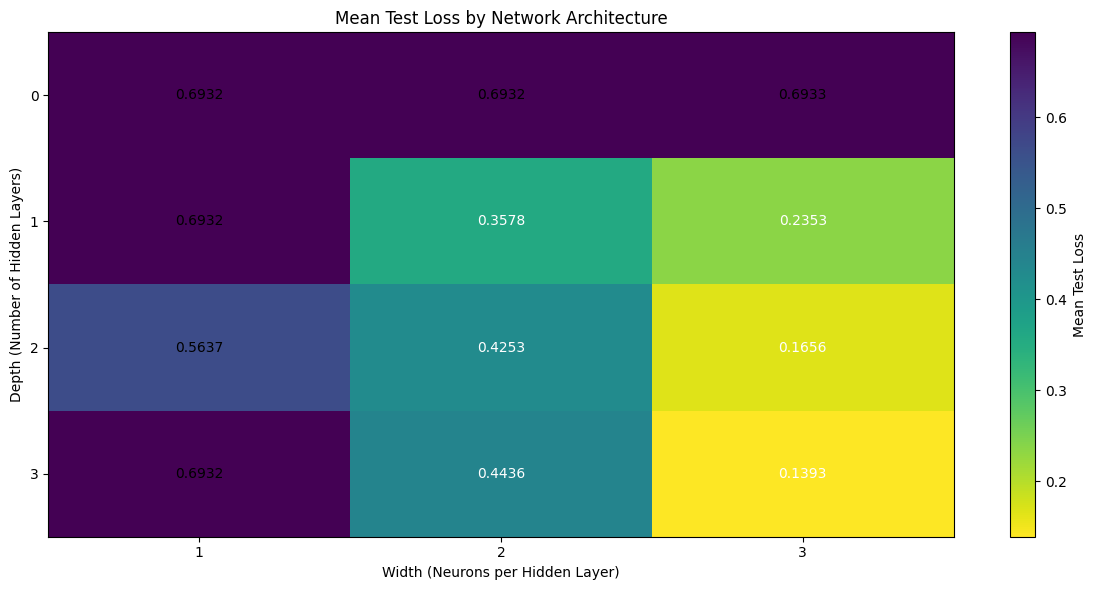

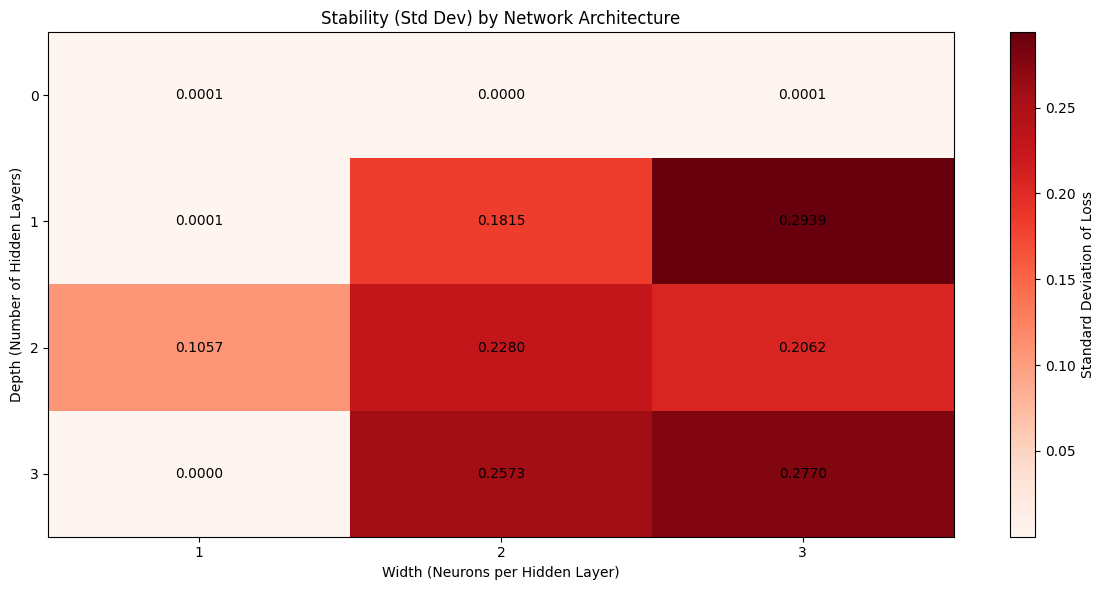

In [38]:
# Visualize the results
plt.figure(figsize=(12, 6))

# Pivot data for heatmap
pivot_table = results_df.pivot(index='Depth', columns='Width', values='Mean Loss')

# Plot heatmap
plt.imshow(pivot_table, cmap='viridis_r', aspect='auto')
plt.colorbar(label='Mean Test Loss')
plt.xlabel('Width (Neurons per Hidden Layer)')
plt.ylabel('Depth (Number of Hidden Layers)')
plt.title('Mean Test Loss by Network Architecture')

# Set ticks
plt.xticks(range(len(widths)), widths)
plt.yticks(range(len(depths)), depths)

# Add text annotations
for i in range(len(depths)):
    for j in range(len(widths)):
        value = pivot_table.iloc[i, j]
        plt.text(j, i, f'{value:.4f}', ha='center', va='center', color='white' if value < 0.5 else 'black')

plt.tight_layout()
plt.show()

# Also plot standard deviation
plt.figure(figsize=(12, 6))
pivot_std = results_df.pivot(index='Depth', columns='Width', values='Std Dev')
plt.imshow(pivot_std, cmap='Reds', aspect='auto')
plt.colorbar(label='Standard Deviation of Loss')
plt.xlabel('Width (Neurons per Hidden Layer)')
plt.ylabel('Depth (Number of Hidden Layers)')
plt.title('Stability (Std Dev) by Network Architecture')
plt.xticks(range(len(widths)), widths)
plt.yticks(range(len(depths)), depths)

for i in range(len(depths)):
    for j in range(len(widths)):
        value = pivot_std.iloc[i, j]
        plt.text(j, i, f'{value:.4f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.show()